# Experimental Evaluation

This Jupyter Notebook contains scripts for calculating variances, correlation coefficients, and other statistics for the correlation analysis and performance evaluation of ISS-MAPF-LNS and MAPF-LNS. For more details, refer to Sections 4 and 5 of the paper located in the pub directory.

### Correlation and Variance Analysis


random-32-32-20-k-150-ns-16-initsol-030-runs-030

Correlation coefficients and variances:
   Scenario  Overall Mean  Overall Std  Mean of Stds  Correlation Coefficient
0         1   3841.510667    10.277916     15.062389                 0.215121
1         2   3605.368452     5.929369     11.932649                 0.242598
2         3   3482.772222     6.832697     12.058790                 0.130271
3         4   3639.093678     8.942418     13.512467                -0.018240
4         5   3831.215079    11.199967     16.629243                 0.146978
5         6   3656.743678     7.857673     13.822231                -0.478117
6         7   3693.613218    12.207270     20.952875                 0.062798
7         8   3816.054444     9.891137     20.084676                -0.156871
8         9   3768.623563    12.194539     18.191208                 0.098372
9        10   3482.842222     7.318056     13.350329                -0.453595
10       11   3638.182222     7.628399     15.08418

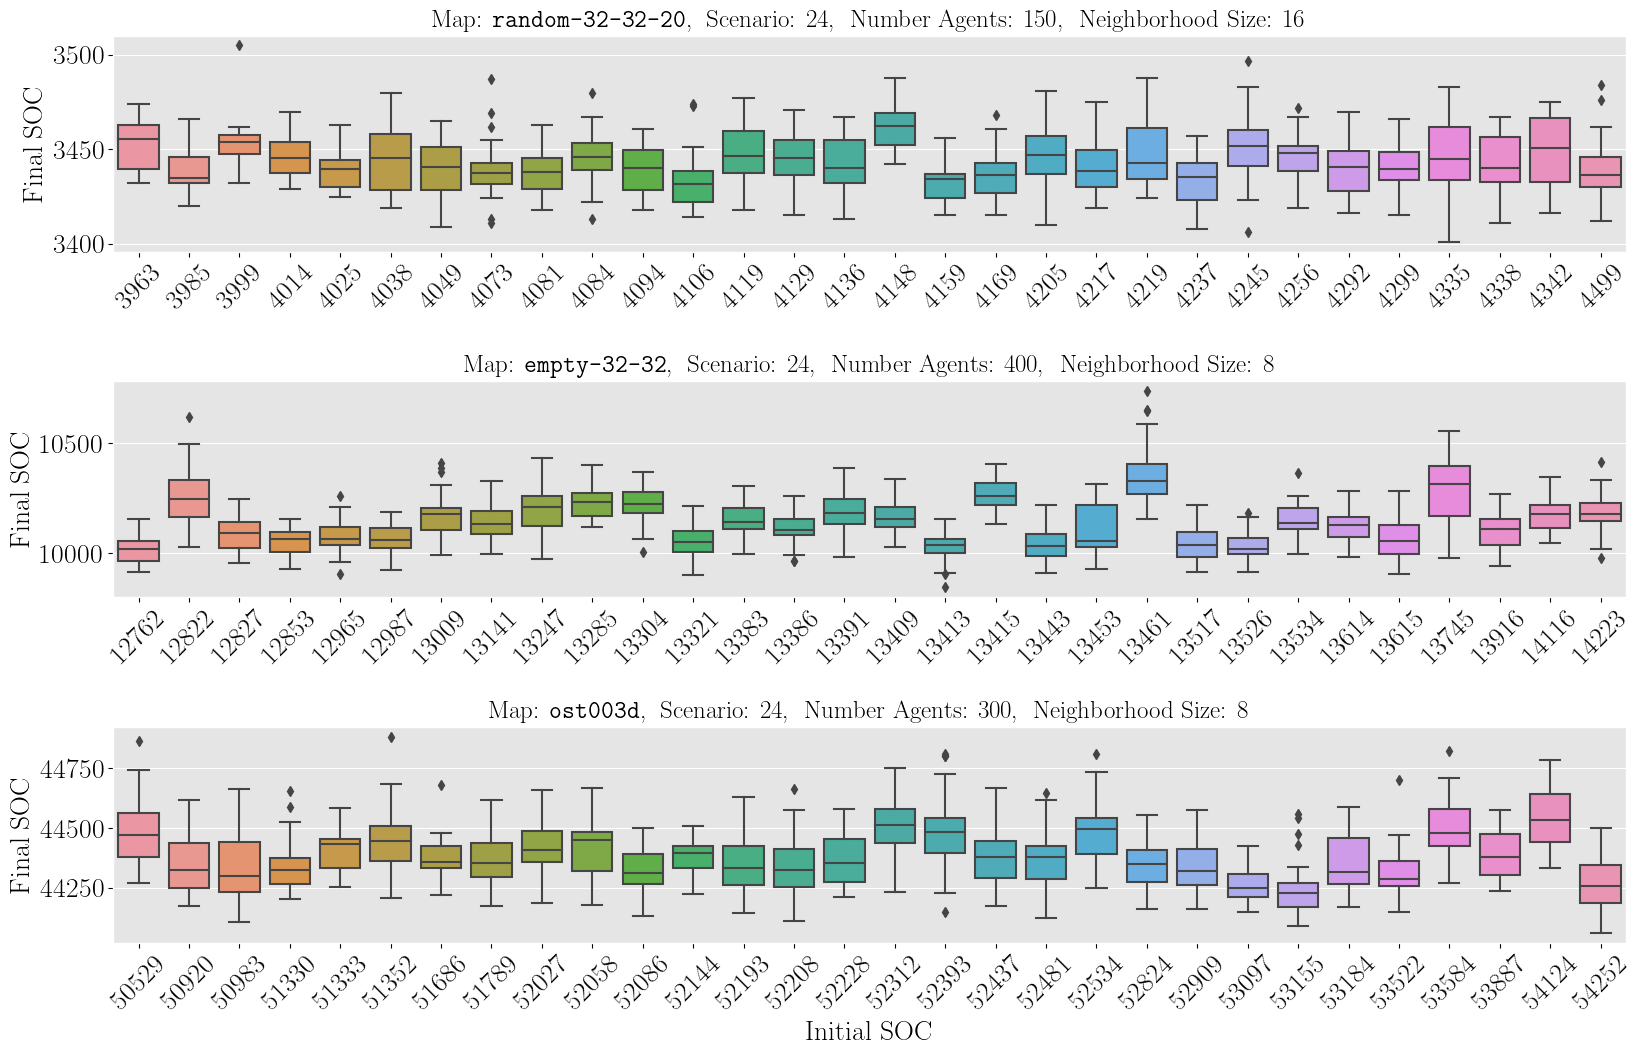

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 25,  # Base font size
    "axes.labelsize": 20,  # Font size for x and y labels
    "xtick.labelsize": 20,  # Font size for x-axis tick labels
    "ytick.labelsize": 20,  # Font size for y-axis tick labels
    "legend.fontsize": 20,  # Font size for legends
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

def process_file(df):
    """Process DataFrame by grouping and handling duplicate initial solution costs."""
    df['Group'] = df.index // 30
    unique_costs = df.groupby('Group')['initial solution cost'].first()
    counts = {}
    for i, cost in enumerate(unique_costs):
        key = str(cost)
        if key not in counts:
            counts[key] = 0
        else:
            counts[key] += 1
            unique_costs.iloc[i] = f"{cost}_{counts[key]}"
    for i, cost in enumerate(unique_costs):
        df.loc[df['Group'] == i, 'initial solution cost'] = cost
    return df

def read_csv_files(directory):
    """Read all CSV files from the directory and return a dictionary of DataFrames."""
    dataframes = {}
    filepaths = sorted(glob.glob(os.path.join(directory, '*.csv')))
    for filepath in filepaths:
        filename = os.path.basename(filepath)
        if 'init' in filename.lower():
            continue
        df = pd.read_csv(filepath)
        dataframes[filename] = df
    return dataframes

def plot_scenario(dataframes, scenario, subfolder, ax, show_xlabel):
    """Plot boxplot for each scenario in the DataFrame."""
    for filename, df in dataframes.items():
        if df.empty:
            continue
        
        scenario_num = filename.split('-')[2].lstrip('0')
        if scenario_num != scenario:
            continue
        
        map_name = subfolder.split('-k')[0]
        wider_space = "\u00A0" * 2  # Adjust the number to increase or decrease the space

        # Create the title with wider spaces
        title = (
            f"Map: \\texttt{{{map_name}}},{wider_space}Scenario: ${scenario_num}$,{wider_space}"
            f"Number Agents: ${subfolder.split('-k-')[1].split('-ns')[0].lstrip('0')}$,{wider_space}"
            f"Neighborhood Size: ${subfolder.split('-ns-')[1].split('-initsol')[0].lstrip('0')}${wider_space}"
        )

        # Convert columns to numeric and drop NaNs
        df['initial solution cost'] = pd.to_numeric(df['initial solution cost'], errors='coerce')
        df['solution cost'] = pd.to_numeric(df['solution cost'], errors='coerce')
        df.dropna(subset=['initial solution cost', 'solution cost'], inplace=True)
        
        df['initial solution cost'] = df['initial solution cost'].astype(float).apply(lambda x: int(x) if x.is_integer() else x)

        # Map each unique 'initial solution cost' to a color
        unique_costs = df['initial solution cost'].unique()
        colors = plt.cm.get_cmap('viridis', len(unique_costs))
        color_dict = dict(zip(unique_costs, colors.colors))
        df['color'] = df['initial solution cost'].map(color_dict)

        # Boxplot for each unique 'initial solution cost'
        sns.boxplot(x='initial solution cost', y='solution cost', data=df, ax=ax)

        ax.set_ylabel('Final SOC')
        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

        if show_xlabel:
            ax.set_xlabel('Initial SOC')
        else:
            ax.set_xlabel('')

def calculate_statistics(dataframes):
    """Calculate statistics for each scenario in the DataFrames."""
    results = []
    for filename, df in dataframes.items():
        scenario_num = filename.split('-')[2].lstrip('0')

        # Group by 'initial solution cost' and calculate the mean and std of 'solution cost'
        grouped = df.groupby('initial solution cost')['solution cost'].agg(['mean', 'std']).reset_index()

        # Calculate overall mean and std of the grouped mean 'solution cost'
        overall_mean = grouped['mean'].mean()
        overall_std = grouped['mean'].std()

        # Calculate the mean of std within each group
        mean_of_std = grouped['std'].mean()

        # Calculate correlation of the means
        corr, p = scipy.stats.pearsonr(grouped['initial solution cost'], grouped['mean'])

        results.append({
            'Scenario': scenario_num,
            'Overall Mean': overall_mean,
            'Overall Std': overall_std,
            'Mean of Stds': mean_of_std,
            'Correlation Coefficient': corr
        })

    return pd.DataFrame(results)

def box_plot(subfolders, data_path, scenario, img_output_dir):
    """Create and display box plots for each subfolder and scenario."""
    fig, axes = plt.subplots(nrows=len(subfolders), ncols=1, figsize=(17, 3.7 * len(subfolders)))
    if len(subfolders) == 1:
        axes = [axes]  # Ensure axes is always a list

    for i, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_path, subfolder)
        dataframes = read_csv_files(folder_path)
        show_xlabel = (i == len(subfolders) - 1)  # Only show x-label for the last subplot
        plot_scenario(dataframes, scenario, subfolder, axes[i], show_xlabel)
        
        # Calculate and display statistics after all plots
        statistics_df = calculate_statistics(dataframes)
        print(f"\n{subfolder}\n\nCorrelation coefficients and variances:")
        print(statistics_df)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6)  # Adjust spacing between plots

    plt.show()

# Define subfolders and call the function
subfolders = [
    "random-32-32-20-k-150-ns-16-initsol-030-runs-030",
    "empty-32-32-k-400-ns-08-initsol-030-runs-030",
    "ost003d-k-300-ns-08-initsol-030-runs-030"
]

data_path = os.path.join(os.getcwd(), 'machine_learning/correlation_variance_analysis')
scenario = '24'
img_output_dir = ""

box_plot(subfolders, data_path, scenario, img_output_dir)


### Results of Performance Evaluation

In [2]:
import pandas as pd
import os

# Set display options to adjust column width and alignment
pd.set_option('display.max_colwidth', None)  # Do not truncate column contents
pd.set_option('display.colheader_justify', 'center')  # Center column headers

def read_and_append(file_path, scenario, folder_name, df):
    """Read a CSV file and append it to the given DataFrame with the scenario number and folder name."""
    temp_df = pd.read_csv(file_path)
    temp_df['Scenario'] = scenario
    temp_df['Folder'] = folder_name  # Add the folder name as a column
    return pd.concat([df, temp_df], ignore_index=True)

def process_files(directory_path, prefix):
    """Process files with a given prefix in the directory and return a DataFrame."""
    df = pd.DataFrame()
    folder_name = os.path.basename(directory_path)  # Get the folder name
    for file in os.listdir(directory_path):
        if file.startswith(prefix) and not file.endswith("initLNS.csv"):
            scenario_number = file.split('-')[2]
            file_path = os.path.join(directory_path, file)
            df = read_and_append(file_path, scenario_number, folder_name, df)
    return df

def calculate_statistics(df):
    """Calculate various statistics for the given DataFrame."""
    numeric_columns = df.select_dtypes(include=['number']).columns
    numeric_df = df[numeric_columns.union(['Scenario', 'Folder'])]

    numeric_df = numeric_df.copy()  # Create a copy to avoid SettingWithCopyWarning
    numeric_df['Initial SOD'] = numeric_df['initial solution cost'] - numeric_df['sum of distance']
    numeric_df['SOD'] = numeric_df['solution cost'] - numeric_df['sum of distance']
    
    columns_to_include = ['runtime', 'solution cost', 'initial solution cost', 'sum of distance',
                          'runtime of initial solution', 'runtime of initial solutions generation', 
                          'runtime of best initial solution prediction', 'area under curve', 'Initial SOD', 'SOD']
    
    numeric_columns_to_include = [col for col in columns_to_include if col in numeric_df.columns]
    
    scenario_means = numeric_df.groupby(['Scenario', 'Folder'])[numeric_columns_to_include].mean().reset_index()
    mean_of_scenario_means = scenario_means.groupby('Folder')[numeric_columns_to_include].mean().reset_index()
    std_scenario_mean = scenario_means.groupby('Folder')[numeric_columns_to_include].std().reset_index()
    
    return mean_of_scenario_means, std_scenario_mean

def process_and_display_results(directory_paths):
    """Process the directories and display the final DataFrame."""
    all_merged_dfs = []

    # Process files from all directories
    for directory_path in directory_paths:
        directory_path = directory_path.rstrip('/')  # Ensure no trailing slash
        subdirectory = os.path.basename(directory_path)

        # Process LNS and ML-LNS files
        combined_df_LNS = process_files(directory_path, "test-LNS-")
        combined_df_ML_LNS = process_files(directory_path, "testML-LNS-")

        # Ensure 'Scenario' column exists
        if 'Scenario' not in combined_df_LNS.columns or 'Scenario' not in combined_df_ML_LNS.columns:
            print(f"Skipping directory {directory_path} as 'Scenario' column is missing.")
            continue

        # Calculate statistics for the combined DataFrames
        stats_LNS = calculate_statistics(combined_df_LNS)
        stats_ML_LNS = calculate_statistics(combined_df_ML_LNS)

        combined_df_ML_LNS = pd.concat(stats_ML_LNS)
        combined_df_LNS = pd.concat(stats_LNS)

        # Create the main DataFrame
        df = pd.DataFrame({
            'Folder': combined_df_ML_LNS['Folder'],
            'ISS Initial SOD': combined_df_ML_LNS['Initial SOD'],
            'LNS Initial SOD': combined_df_LNS['Initial SOD'],
            'ISS Final SOD': combined_df_ML_LNS['SOD'],
            'LNS Final SOD': combined_df_LNS['SOD'],
            'ISS AUC': combined_df_ML_LNS['area under curve'],
            'LNS AUC': combined_df_LNS['area under curve'],
            'ISS t_init': combined_df_ML_LNS['runtime of initial solutions generation'],
            'LNS t_init': combined_df_LNS['runtime of initial solution']
        })

        # Round all numeric values in the DataFrame to two decimal places
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].round(2)

        # Merge values for columns with appropriate formatting
        merged_values = []
        for col in df.columns:
            first_value = df.iloc[0][col]
            second_value = df.iloc[1][col]
            if pd.api.types.is_numeric_dtype(df[col]):
                merged_value = f"{first_value:.2f}"  # Format the first value to two decimal places
            else:
                merged_value = first_value
            merged_values.append(merged_value)

        # Create a new DataFrame with the merged values
        merged_df = pd.DataFrame([merged_values], columns=df.columns)
        
        all_merged_dfs.append(merged_df)

    # Combine all merged DataFrames and display
    if all_merged_dfs:
        final_df = pd.concat(all_merged_dfs)
        display(final_df)
    else:
        print("No valid dataframes to display.")

# Base directory path for results
base_path = os.path.join(os.getcwd(), 'machine_learning/results/')

# List of directories to process in the specified order
directory_paths = [
   base_path + "empty-8-8-k-016-ns-16-initsol-030-runs-041",
   base_path + "empty-8-8-k-024-ns-16-initsol-030-runs-041",
   base_path + "empty-8-8-k-032-ns-16-initsol-030-runs-041",
   base_path + "empty-32-32-k-300-ns-08-initsol-030-runs-041",
   base_path + "empty-32-32-k-350-ns-08-initsol-030-runs-041",
   base_path + "empty-32-32-k-400-ns-08-initsol-030-runs-041",
   base_path + "empty-32-32-k-450-ns-08-initsol-030-runs-041",
   base_path + "ost003d-k-100-ns-08-initsol-030-runs-041",
   base_path + "ost003d-k-200-ns-08-initsol-030-runs-041",
   base_path + "ost003d-k-300-ns-08-initsol-030-runs-041",
   base_path + "ost003d-k-400-ns-08-initsol-030-runs-041",
   base_path + "random-32-32-20-k-050-ns-16-initsol-030-runs-041",
   base_path + "random-32-32-20-k-100-ns-16-initsol-030-runs-041",
   base_path + "random-32-32-20-k-150-ns-16-initsol-030-runs-041",
   base_path + "random-32-32-20-k-200-ns-16-initsol-030-runs-041",
   base_path + "random-32-32-20-k-250-ns-16-initsol-030-runs-041",
   base_path + "warehouse-10-20-10-2-1-k-150-ns-16-initsol-030-runs-041",
   base_path + "warehouse-10-20-10-2-1-k-200-ns-16-initsol-030-runs-041",
   base_path + "warehouse-10-20-10-2-1-k-250-ns-16-initsol-030-runs-041",
   base_path + "warehouse-10-20-10-2-1-k-300-ns-16-initsol-030-runs-041",
   base_path + "warehouse-10-20-10-2-1-k-350-ns-16-initsol-030-runs-041"
]

# Call the function to process and display results
process_and_display_results(directory_paths)

,Folder,ISS Initial SOD,LNS Initial SOD,ISS Final SOD,LNS Final SOD,ISS AUC,LNS AUC,ISS t_init,LNS t_init
0,empty-8-8-k-016-ns-16-initsol-030-runs-041,10.56,10.72,2.52,2.52,151.26,151.26,0.01,0.00
0,empty-8-8-k-024-ns-16-initsol-030-runs-041,34.28,35.06,10.43,10.43,629.89,629.60,0.02,0.00
0,empty-8-8-k-032-ns-16-initsol-030-runs-041,93.76,82.56,25.13,25.19,1545.09,1548.53,0.09,0.00
0,empty-32-32-k-300-ns-08-initsol-030-runs-041,2372.84,2371.52,440.09,442.37,33518.82,33632.40,2.69,0.09
0,empty-32-32-k-350-ns-08-initsol-030-runs-041,3231.12,3230.97,939.54,942.58,70978.30,71157.98,5.42,0.18
0,empty-32-32-k-400-ns-08-initsol-030-runs-041,4363.44,4354.11,1805.67,1791.05,132203.40,130981.41,11.61,0.37
0,empty-32-32-k-450-ns-08-initsol-030-runs-041,6170.04,6045.67,3134.15,3101.54,219306.41,216669.17,29.69,0.98
0,ost003d-k-100-ns-08-initsol-030-runs-041,1441.40,1242.43,43.67,41.27,4021.85,3698.54,3.46,0.10
0,ost003d-k-200-ns-08-initsol-030-runs-041,3902.96,4000.67,217.78,220.86,30693.53,31512.05,11.43,0.35
0,ost003d-k-300-ns-08-initsol-030-runs-041,7970.24,7985.14,932.51,968.17,120037.50,123283.20,22.36,0.74
